# Uncertainty propagation of microkinetic modeling for water gas shift reaction

In [1]:
# load packages
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel as C
import utils

In [2]:
# GP train setting

# basis function
Basis = ['outer_electron', 'inner_shell', \
         'coord_num', 'valence', 'num_non_hydro', \
         'M-C', 'M-O', 'M-H', 'PW91RelEnergy', '#CH3OH', '#H2O', '#H2']
Nstart = 10000    # GP restart optimization

limit_C = 100;    # lower bound for noise level
limit_l = 1e-6    # lower bound for lengthscale
isotropic_kernel = False                           # ARD kernel

Scale = 'MinMax'  # standardize method
Functional = 'Err_RelEnergy'
WGSFxn = 'PW91BindEnergy'

gp_trainfile = './Benchmark_data/Campbell_Mavrikakis_rel_v1.csv'    # gp training file
metal_file = './Benchmark_data/metal_constant.csv'

In [3]:
# pre-calculated hyperparameters
hyp  = [7.767450383154461, 5.757596027338672, -0.1228293962244263, 13.009740697566935, -0.5650730981457128, 10.186156540562594, 11.525166763586267, 8.708465224255864, 4.749814718016643, -0.4903878616734594, 6.171236719199616, 10.708422581386317, -0.33423780342364817, 4.605170185988092]

In [4]:
# Load and preprocessing the data
sorp_data = utils.read_file(gp_trainfile)
utils.outer_electron(sorp_data, metal_file)
utils.inner_shell(sorp_data, metal_file)
utils.coordination_num(sorp_data, metal_file)

# build training data
Xtrain = [sorp_data[base] for base in Basis]
Xtrain = np.array(Xtrain).T 
Ndata, Nfeature = Xtrain.shape

# Scaling
if Scale == 'MinMax':
    mms = MinMaxScaler()
    Xtrain = mms.fit_transform(Xtrain)
elif Scale == 'Std':
    stdsc = StandardScaler()
    Xtrain = stdsc.fit_transform(Xtrain)
    
# Output
Ytrain = -np.array(sorp_data[Functional])

In [5]:
# Define the kernel and GP model 
if isotropic_kernel:
    k1 = C(1, (1e-6, 1e6)) * RBF(1, (limit_l, 1e6))
else:  
    k1 = C(1, (1e-6, 1e6)) * RBF(np.ones(Nfeature), (limit_l, 1e6))
k2 = WhiteKernel(noise_level=1,
                  noise_level_bounds=(100, 1e6))  # noise terms
kernel = k1+k2
gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)

hyp = np.array(hyp)
gpr.kernel.theta = hyp          # laod the hyperparameters
gpr.fit(Xtrain, Ytrain)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=48.6**2 * RBF(length_scale=[317, 0.884, 4.47e+05, 0.568, 2.65e+04, 1.01e+05, 6.05e+03, 116, 0.612, 479, 4.47e+04, 0.716]) + WhiteKernel(noise_level=100),
             n_restarts_optimizer=0, normalize_y=False, optimizer=None,
             random_state=None)

In [6]:
# apply GP for the species applied in microkinetic model

gp_predictfile = './Benchmark_data/InputMetSynGP.csv'

# build predict input
GPpred_data = utils.read_file(gp_predictfile)
utils.site_dis(GPpred_data, metal_file)
utils.outer_electron(GPpred_data, metal_file)
utils.inner_shell(GPpred_data, metal_file)
utils.coordination_num(GPpred_data, metal_file)
Adsorbate = GPpred_data['Adsorbate']

# WGS Input
Xpred = [GPpred_data[base] for base in Basis]
Xpred = np.array(Xpred).T
Npred, _ = Xpred.shape

if Scale == 'MinMax':
    Xpred = mms.transform(Xpred)
elif Scale == 'Std':
    Xpred = stdsc.transform(Xpred)

# GP prediction on gp_predictfile
GPpred, SigGPpred = gpr.predict(Xpred, return_std=True)

## Microkinetic modeling

In [7]:
# load kinetic module
from AbCD.model import CSTR
from AbCD.io_data import In_data

In [8]:
# load speices and reaction list and reaction condition
sitelist, specieslist, reactionlist = In_data.load_mkm('./WGSdata/')
conditionlist = In_data.load_condition('./WGSdata/')

# which reaction and species are defined are varied in microkinetics
dEa_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
dBE_index = [4, 5, 6, 7, 8, 9, 10, 11]

# define CSTR reactor
reactor = CSTR(specieslist=specieslist,
              reactionlist=reactionlist,
              dEa_index=dEa_index,
              dBE_index=dBE_index)
reactor.initialize()            # initialize the reactor

In [9]:
# sample from GP prediction
Nsample = 300      # number of sample
GPsample = gpr.sample_y(Xpred, n_samples=Nsample)


tor_sample = []
for i in range(Nsample):
    if i % 100 == 0:
        print(i)
    # assign GP prediction to species deviation
    GPpred = GPsample[:, i]
    for ii, spe in enumerate(specieslist):
        try:
            idx = Adsorbate.index(str(spe))
            spe.dE = GPpred[idx]
        except:
            pass
    
    # dEa_ follows the BEP relationship
    dBE_ = []
    for i in dBE_index:
        spe = specieslist[i]
        idx = Adsorbate.index(str(spe))
        dBE_.append(GPpred[idx])
    dEa_ = []
    for i in dEa_index:
        rxn = reactionlist[i]
        dEa_.append(rxn.dft_data['omega'] * rxn.deltaH())
    
    # build input to the microkinetic model
    dP = dEa_ + dBE_
    if not reactor.CheckThermoConsis(dP):    # check thermodynamic consistency
        dP = reactor.CorrThermoConsis(dP)

    try:
        tor_list = []
        for condi in conditionlist:
            tor, _ = reactor.fwd_simulation(dP, condi)     # forward simulation
            tor_list.append(-tor['CO(g)'])
        tor_sample.append(tor_list)
    except:
        pass
    
tor_sample = np.array(tor_sample)
print('Total simulation = %d' %Nsample)
print('Availabe simulation = %d' %len(tor_sample))

0
100
200
Total simulation = 300
Availabe simulation = 279


In [10]:
# microkinetic model without GP correction
tor_nogp = []
dP = np.zeros(len(dEa_index) + len(dBE_index))
if not reactor.CheckThermoConsis(dP):    # check thermodynamic consistency
    dP = reactor.CorrThermoConsis(dP)    # correct thermodynamic consistency

for condi in conditionlist:
    tor, _ = reactor.fwd_simulation(dP, condi, reltol=1e-14, abstol=1e-16)     # forward simulation
    tor_nogp.append(-tor['CO(g)'])

In [11]:
# visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

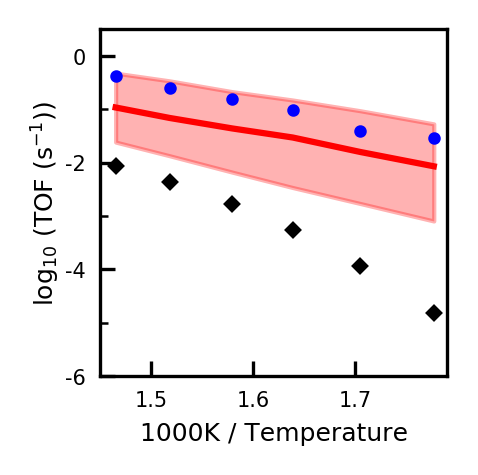

In [12]:
tor_exp = [-condi.TurnOverFrequency['CO(g)'] for condi in conditionlist]
Tem = [condi.Temperature for condi in conditionlist]

Acti = tor_sample[:, 0:6]
Acti_nogp = tor_nogp[0:6]
Acti_exp = tor_exp[0:6]
Tem_Acti = [1000/tt for tt in Tem][0:6]


logActi = np.log10(Acti)
logActi_exp = np.log10(Acti_exp)
logActi_nogp = np.log10(Acti_nogp)

# Arrhenius Plot
fig = plt.figure(figsize=(1.5, 1.5), dpi=300)
ax = fig.gca()

ax.plot(Tem_Acti, np.median(logActi, axis = 0), 'r-', label='GP-DFT')
p16 = np.percentile(logActi, 16, axis=0)
p84 = np.percentile(logActi, 84, axis=0)
ax.fill_between(Tem_Acti,p16, p84, alpha=0.3, color='r')  # Draw red shade between 16 and 84
ax.plot(Tem_Acti, logActi_exp, 'bo', ms=2, label='Exp')
ax.plot(Tem_Acti, logActi_nogp, 'kD', ms=2, label='DFT')
# Linear fit
fit_exp = np.polyfit(Tem_Acti, logActi_exp, 1)
fit_fn_exp = np.poly1d(fit_exp)
fit_nogp = np.polyfit(Tem_Acti, logActi_nogp, 1)
fit_fn_nogp = np.poly1d(fit_nogp) 
xx = [1.4, 1.8]
# Line
#ax.plot(xx, fit_fn_exp(xx), 'b:')
#ax.plot(xx, fit_fn_nogp(xx), 'k:')
tickform = '%d'

major = 2
minor = 1
majorLocator = MultipleLocator(major)
majorFormatter = FormatStrFormatter(tickform)
minorLocator = MultipleLocator(minor)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

ax.tick_params(axis='x', which='major', direction='in', labelsize=5)
ax.tick_params(axis='y', which='major', direction='in', labelsize=5)
ax.tick_params(axis='y', which='minor', direction='in', labelsize=5)


ax.set_xlabel('1000K / Temperature', fontsize=6)
ax.set_ylabel(r'log$_{10}$ (TOF (s$^{-1}$))', fontsize=6)

ax.xaxis.set_label_coords(0.50, -0.13)
ax.yaxis.set_label_coords(-0.11, 0.50)

ax.set_ylim([-6, 0.5])
ax.set_xlim([1.45, 1.79])


plt.subplots_adjust(top=0.95,
                    bottom=0.18,
                    left=0.18,
                    right=0.95,
                    hspace=0.2,
                    wspace=0.2)